In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import add_labels, get_label_rotation

df1 = pd.read_csv("data/employment-rates.csv")
df1["metric"] = "unemployment"
df1.rename(columns={
    "unemployment_rate": "value"
}, inplace=True)
df1_female = df1[df1["sex"]=="Female"]
df1_male = df1[df1["sex"]=="Male"]
df1 = df1_female.merge(
    df1_male,
    left_on=["island", "year", "age", "metric"],
    right_on=["island", "year", "age", "metric"],
    how="inner",
    suffixes=("_female", "_male")
)

df2 = pd.read_csv("data/education-level.csv")
df2.replace({
   "Early childhood education": "Highschool and below",
   "Primary education": "Highschool and below",
   "Lower secondary education": "Highschool and below",
   "Upper secondary education": "Highschool and below",
   "Post-secondary non-tertiary education": "After highschool",
   "Tertiary education": "After highschool"
}, inplace=True)
df2["metric"] = "n_people"
df2.rename(columns={
    "count": "value"
}, inplace=True)
df2_female = df2[df2["sex"]=="Female"]
df2_male = df2[df2["sex"]=="Male"]
df2 = df2_female.merge(
    df2_male,
    left_on=["island", "year", "age", "level", "metric"],
    right_on=["island", "year", "age", "level", "metric"],
    how="inner",
    suffixes=("_female", "_male")
).sample(20)

df3 = pd.read_csv("data/management-position.csv")
df3.drop(columns="categories", inplace=True)
df3["metric"] = "share-manager"
df3.rename(columns={
    "share_female_lead": "value"
}, inplace=True)
df3["value_male"] = 100 - df3["value"]
df3.rename(columns={"value": "value_female"}, inplace=True)

df = pd.concat([df1, df2, df3])
df.drop(columns=["sex_male", "sex_female", "level"], inplace=True)
df.replace("Micronesia (Federated States of)", "Micronesia", inplace=True)
df["name"] = ""

max_per_metric = df.groupby("metric")[["value_female", "value_male"]].max().reset_index()
max_per_metric.columns = ["metric", "max_female", "max_male"]
df = df.merge(max_per_metric, on="metric")
df["value_female_scaled"] = df["value_female"]/df["max_female"]*50
df["value_male_scaled"] = df["value_male"]/df["max_male"]*50
df

,island,year,value_female,age,metric,value_male,name,max_female,max_male,value_female_scaled,value_male_scaled
0,Cook Islands,2015,1.44,25-54,unemployment,1.71,,36.63,24.7,1.965602,3.461538
1,Kiribati,2015,36.63,25-54,unemployment,24.70,,36.63,24.7,50.000000,50.000000
2,Kiribati,2015,14.24,55-64,unemployment,12.52,,36.63,24.7,19.437619,25.344130
3,Kiribati,2019,6.23,25-54,unemployment,5.97,,36.63,24.7,8.503959,12.085020
4,Marshall Islands,2011,1.00,25-54,unemployment,0.59,,36.63,24.7,1.365001,1.194332
...,...,...,...,...,...,...,...,...,...,...,...
56,Micronesia,2013,21.80,25-54,share-manager,78.20,,54.30,92.7,20.073665,42.179072
57,Marshall Islands,2019,12.10,55-64,share-manager,87.90,,54.30,92.7,11.141805,47.411003
58,Marshall Islands,2019,33.20,25-54,share-manager,66.80,,54.30,92.7,30.570902,36.030205
59,Kiribati,2019,44.30,55-64,share-manager,55.70,,54.30,92.7,40.791897,30.043150


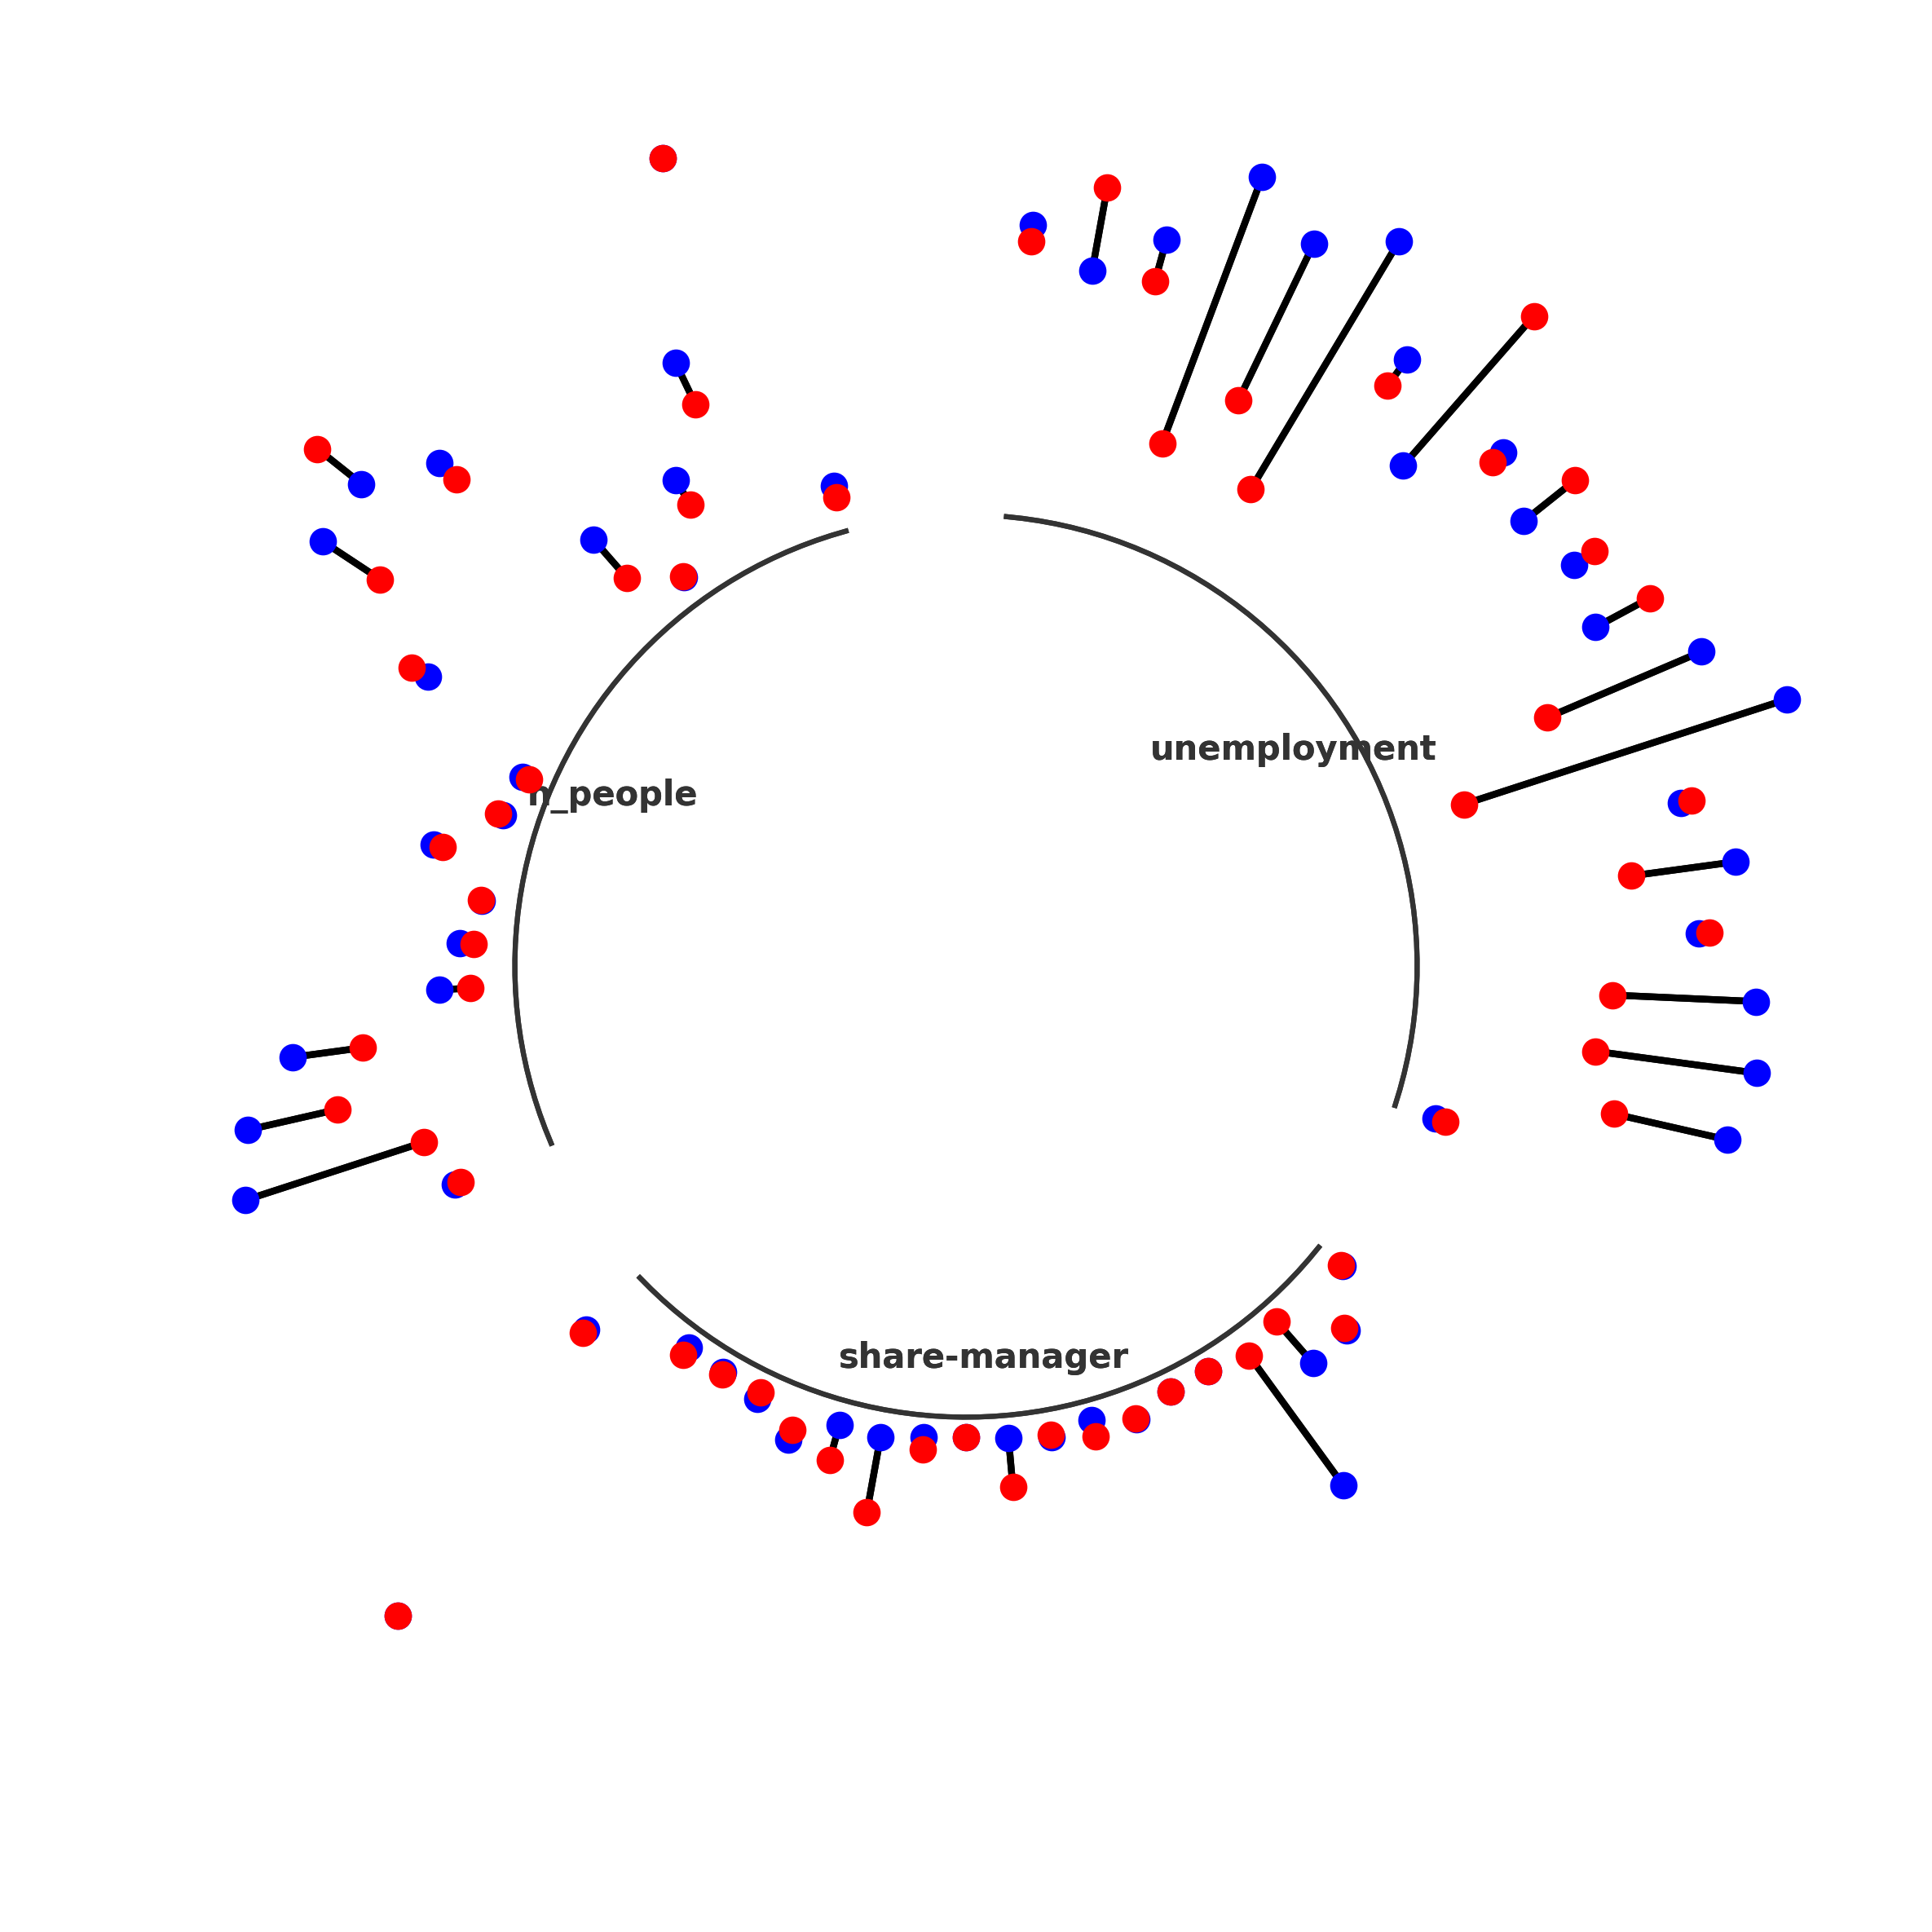

In [272]:
def circular_lollipop(df, value, name, group, fig, ax, color, other_values):
    VALUES = df[value].values*2
    OTHER_VALUES = df[other_values].values*2
    LABELS = df[name].values
    GROUP = df[group].values

    PAD = 3
    ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
    ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
    WIDTH = (2 * np.pi) / len(ANGLES)

    GROUPS_SIZE = [len(i[1]) for i in df.groupby(group)]

    offset = 0
    IDXS = []
    for size in GROUPS_SIZE:
        IDXS += list(range(offset + PAD, offset + size + PAD))
        offset += size + PAD

    ax.set_theta_offset(np.pi/2)
    ax.set_ylim(-120, 120)
    ax.set_frame_on(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    GROUPS_SIZE = [len(i[1]) for i in df.groupby(group)]
    COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

    # Calculate the minimum and maximum values for each pair
    BOTTOMS = np.minimum(VALUES, OTHER_VALUES)
    TOPS = np.maximum(VALUES, OTHER_VALUES)

    # Plot lines
    for angle, bottom, top in zip(ANGLES[IDXS], BOTTOMS, TOPS):
        ax.plot([angle, angle], [bottom, top], color='black', linewidth=2)

    # Plot markers
    ax.scatter(ANGLES[IDXS], VALUES, color=color, s=50, zorder=10)

    # Add labels
    for angle, value, label in zip(ANGLES[IDXS], VALUES, LABELS):
        ha = 'left' if np.pi/2 <= angle <= 3*np.pi/2 else 'right'
        ax.text(angle, value + 5, label, ha=ha, va='center', rotation=np.degrees(angle - np.pi/2))

    offset = 0 
    for group, size in zip(np.unique(GROUP), GROUPS_SIZE):
        x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
        ax.plot(x1, [-5] * 50, color="#333333")
        ax.text(
            np.mean(x1), -20, group, color="#333333", fontsize=10, 
            fontweight="bold", ha="center", va="center"
        )
        
        offset += size + PAD

# Usage
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"}, dpi=300)
circular_lollipop(
   df=df,
   value="value_male_scaled",
   name="name",
   group="metric",
   fig=fig,
   ax=ax,
   color="blue",
   other_values="value_female_scaled"
)
circular_lollipop(
   df=df,
   value="value_female_scaled",
   name="name",
   group="metric",
   fig=fig,
   ax=ax,
   color="red",
   other_values="value_male_scaled"
)

plt.show()